In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
import os
from scipy import interpolate
from scipy.optimize import curve_fit
#from parfor import parfor
import time
import pdb

In [2]:
#Adapted RSC computation to deal with unknown sign convention anomaly on Aft antenna
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    dswasv = seastar.gmfs.doppler.compute_wasv(level1, aux, gmf)
#     if level1.Antenna =='Aft':
#         rsc = -level1.RadialSurfaceVelocity - dswasv
#     else:
    rsc = level1.RadialSurfaceVelocity + dswasv
    return rsc
def iqr(da, dim):
    """Calculates interquartile range"""
    return (da.quantile(q=0.75, dim=dim) - da.quantile(q=0.25, dim=dim)).rename("iqr")


In [3]:
fig_folder='D:\\OneDrive - NERC\\OneDrive - NERC\\SEASTAR\\PM WP4000\\figures\\'
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# L1a to L1b processing

In [4]:
version = 'v20230215'
#version='v20221104_2'
flight = '20220522'
file_paths = ss.utils.readers._set_file_paths()
oscar_path = os.path.join(file_paths['oscar_path'], version, flight, 'matlab-pre-processed','')
#oscar_path = os.path.join(file_paths['oscar_path'],'v20221104_2', 'matlab-pre-processed','')
file_time_triplets = ss.oscar.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing - version ' + version)
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

DAR_tracks = ss.utils.readers._read_DAR_config(flight)
DAR_tracks = {'Track_11':3,'Track_12':4,'Track_13':5,'Track_14':6,'Track_15':7,'Track_16':8,'Track_17':9,'Track_18':10}
#DAR_tracks = {'Track_11':4,'Track_12':5,'Track_13':6,'Track_14':7,'Track_15':8,'Track_16':9,'Track_17':10,'Track_18':11}


# L1a variables to be passed to L1b dataset
vars_to_keep = ['LatImage', 'LonImage', 'IncidenceAngleImage', 'LookDirection', 'SquintImage', 'CentralFreq',
               'OrbitHeadingImage']
ds_L1b = dict()
t= time.time()
# @parfor(range(len(DAR_tracks)), serial=True)
# def ds_L1b(ii):
#     track = list(DAR_tracks.keys())[ii]
for track in DAR_tracks.keys():
    ds_ml = dict()
    file_index = DAR_tracks[track]
    ds_L1a = ss.oscar.tools.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    ds_L1a_dict_index = list(ds_L1a.keys())
    antenna_ident = ss.oscar.tools.identify_antenna_location_from_filename(
                        oscar_path,
                        file_time_triplets[file_index][1])
    antenna_dict = {list(ds_L1a.keys())[i]: antenna_ident[i] for i in range(len(antenna_ident))}
    print('Processing file index',file_index,'...')
    # L1b processing - loop through beams in L1a dataset dict
    #--------------------------------------------------------
    for dict_index in ds_L1a_dict_index:
        ds_L1a[dict_index] = ss.oscar.level1.replace_dummy_values(
                                 ds_L1a[dict_index],
                                 dummy_val=int(ds_L1a[dict_index].Dummy.data))
        ds_ml[dict_index] = ss.oscar.level1.compute_multilooking_Master_Slave(
                                ds_L1a[dict_index],
                                window=7)
        #ds_ml[dict_index]['Polarization'] = ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
        ds_ml[dict_index]['Polarization'] = xr.DataArray(data=np.full(ds_L1a[dict_index].IncidenceAngleImage.shape,
                                                              ss.oscar.level1.check_antenna_polarization(
                                                                  ds_L1a[dict_index]).data),
                                         coords=ds_L1a[dict_index].IncidenceAngleImage.coords,
                                         dims=ds_L1a[dict_index].IncidenceAngleImage.dims)
        ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
        #ds_ml[dict_index]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds_ml[dict_index]['AntennaAzimuthImage'] =ss.oscar.level1.compute_antenna_azimuth_direction(
                                                    ds_L1a[dict_index],
                                                    antenna=antenna_ident[ds_L1a_dict_index.index(dict_index)])
        ds_ml[dict_index]['TimeLag'] = ss.oscar.level1.compute_time_lag_Master_Slave(
                                           ds_L1a[dict_index],
                                           options='from_SAR_time')
        #--------------------------------------------------------------------
        # Save data here
        #---------------------------------------------------------------------
#         if antenna_dict[dict_index] == 'Aft':
        
        if antenna_dict[dict_index] == 'Fore':
            ds_ml[dict_index]['Interferogram'] = ds_ml[dict_index].Interferogram\
            - -0.0025 * ds_L1a[dict_index].IncidenceAngleImage - 0.129
        elif antenna_dict[dict_index] == 'Aft':
            ds_ml[dict_index]['Interferogram'] = ds_ml[dict_index].Interferogram \
            - 0.0043 * ds_L1a[dict_index].IncidenceAngleImage - -0.2364
        
        ds_ml[dict_index][vars_to_keep] = ds_L1a[dict_index][vars_to_keep]
        ds_ml[dict_index]['RadialSurfaceVelocity'] = ss.oscar.level1.compute_radial_surface_velocity(
                                                         ds_ml[dict_index])
        
        ds_ml[dict_index].attrs['Title'] = ds_L1a[dict_index].Title
        ds_ml[dict_index]['TrackTime'] = ss.oscar.level1.track_title_to_datetime(ds_ml[dict_index].Title)
#-----------------------------------------------------------
    ds_ml = ss.oscar.level1.fill_missing_variables(ds_ml, antenna_ident)
# Build L1b dataset
    ds_L1b[track] = ss.oscar.level1.merge_beams(ds_ml, antenna_ident)
    del ds_ml
    #return ds_L1b[track]
print('...Done')
print('Computation loop executed in', np.round(time.time()-t,1), 's')

Device name = LIVPCZG-10
Setting local paths...
OSCAR L1 processing - version v20230215
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\v20230215\20220522\matlab-pre-processed\
-------------------
File index : 0 , Aquisition time : 20220522T053942 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220522T054805 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220522T055458 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220522T062018 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220522T062620 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220522T063239 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220522T063906 , File list indices : [18, 19, 20]
File index : 7 , Aquisition time : 20220522T064459 , File list indices : [21, 22, 23]
File index : 8 , Aquisition time : 20220522T065108 , File list indices : [24, 25, 26]
File i

# L1b to L2 processing

In [5]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')
AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] =\
    xr.open_dataset(AROME_data_folder + file)

AROME_winds = xr.concat(list(AROME_dict.values()), dim='time', join='outer')
del AROME_dict
ds_L2 = dict()
sar_pixel_size=8
rolling_window_metres=200
rolling_window = int(round(rolling_window_metres/sar_pixel_size))
for track in ds_L1b.keys():
    print('Processing ' + track + '...')
    # Generating geophysical data fields for GMF doppler computation
    u10 = AROME_winds.u10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    v10 = AROME_winds.v10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
    aux = ss.oscar.level1.init_auxiliary(ds_L1b[track].IncidenceAngleImage, wind_speed.data, wind_direction.data)
    # Compute RSC
    if flight == '20220517':
        rsc = [compute_radial_surface_current(ds_L1b[track].sel(Antenna=a),
                                              aux.sel(Antenna=a), gmf='mouche12') for a in antenna_ident]
    else:
         rsc = [compute_radial_surface_current(ds_L1b[track].sel(Antenna=a),
                                               aux.sel(Antenna=a), gmf='mouche12') for a in antenna_ident]
    ds_L1b[track]['RadialSurfaceCurrent_mouche12'] = xr.concat(rsc, 'Antenna',join='outer')
    ds_L1b[track]['RadialSurfaceCurrent_mouche12'] = ds_L1b[track].RadialSurfaceCurrent_mouche12\
        .rolling(CrossRange=rolling_window, center=True).mean()\
        .rolling(GroundRange=rolling_window, center=True).mean()
    
    
    if flight == '20220517':
        rsc = [compute_radial_surface_current(ds_L1b[track].sel(Antenna=a),
                                              aux.sel(Antenna=a), gmf='yurovsky19') for a in antenna_ident]
    else:
         rsc = [compute_radial_surface_current(ds_L1b[track].sel(Antenna=a),
                                               aux.sel(Antenna=a), gmf='yurovsky19') for a in antenna_ident]
    ds_L1b[track]['RadialSurfaceCurrent_yurovsky19'] = xr.concat(rsc, 'Antenna',join='outer')
    ds_L1b[track]['RadialSurfaceCurrent_yurovsky19'] = ds_L1b[track].RadialSurfaceCurrent_yurovsky19\
        .rolling(CrossRange=rolling_window, center=True).mean()\
        .rolling(GroundRange=rolling_window, center=True).mean()
    ds_L1b[track]['RadialSurfaceCurrent'] = ds_L1b[track].RadialSurfaceCurrent_yurovsky19
    
    
    
    
    #L2 Processing
    # Initialise l2 dataset
    ds_L2[track] = ss.oscar.level1.init_level2(ds_L1b[track])
    # Compute current magnitude and direction
    ds_L2[track] = seastar.retrieval.level2.compute_current_magnitude_and_direction(ds_L1b[track], ds_L2[track])
    # Compute current vectors
    ds_L2[track]['CurrentVectorUComponent'], ds_L2[track]['CurrentVectorVComponent'] =\
    ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentVelocity'], ds_L2[track]['CurrentDirection'])
    #if list(ds_L2[track].dims.keys())[0] == 'GroundRange':
    #    ds_L2[track] = ds_L2[track][["CrossRange","GroundRange"]]
    ds_L2[track]['TrackTime'] = ds_L1b[track].TrackTime.sel(Antenna='Mid').values
    
print('...Done')

Processing Track_11...
Processing Track_12...


C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


Processing Track_13...
Processing Track_14...
Processing Track_15...
Processing Track_16...
Processing Track_17...
Processing Track_18...
...Done


# Load in and colocate Aux data

In [7]:
# track='Track_11'
# ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(file_paths['xband_file'],
#                                                                    ds_L2[track][["CrossRange","GroundRange"]])
# ds_xband['CurrentVelocity'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
#     compute_Xband_current_magnitude_and_direction(ds_xband)

# folder='unrestricted'
# list22 = {}
# list22['F1'] = 'MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc'
# list22['L1'] = 'MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc'
# list22['W3'] = 'WW3_NORGAS-UG_SEASTAREX_20220517.nc'
# list22['HF_radial'] = 'HF_Brezellec_Radial_2022.nc'
# list22['HF_0522'] = 'HF_combined_20220522.nc'

# os.path.join(file_paths['aux_path'], folder, list22['L1'])
#F1 = xr.open_dataset(file_paths['aux_path'] + folder + list22['F1'])
#L1 = xr.open_dataset(file_paths['aux_path'] + folder + list22['L1'])
#W3 = xr.open_dataset(file_paths['aux_path'] + folder + list22['W3'])
# L1 = xr.open_dataset(os.path.join(file_paths['aux_path'], folder, list22['L1']))

# cvel, cdir = ss.utils.tools.currentUV2VelDir(L1.U.data, L1.V.data)
# L1['CurrentVelocity'] = (('time','nj','ni'), cvel)
# L1['CurrentDirection'] = (('time','nj','ni'), cdir)
# timesel = np.argmin(np.abs(L1.time.data - ds_L1b[track].sel(Antenna='Mid').TrackTime.data))
# L1_CurrentMagnitude_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentVelocity.isel(time=timesel),
#                                                                                  L1.latitude,
#                                                                                  L1.longitude,
#                                                                                  ds_L2[track][["CrossRange","GroundRange"]]
#                                                                                 )
# L1_CurrentDirection_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentDirection.isel(time=timesel),
#                                                                                  L1.latitude,
#                                                                                  L1.longitude,
#                                                                                  ds_L2[track][["CrossRange","GroundRange"]]
#                                                                                 )
# Load Auxiliary data
folder = 'unrestricted\\'
aux_file_list = os.listdir(file_paths['aux_path'] + folder)
MARS2D_files = [filename for filename in aux_file_list if 'MARS2D' in filename]
[filename for filename in MARS2D_files if '0522' in filename]
aux_list=dict()
for data_type in ['MARS2D', 'MARS3D','HF_combined', 'WW3']:
    aux_list[data_type] =xr.open_dataset(
        file_paths['aux_path'] + folder
        + ''.join([f for f in aux_file_list if data_type in f and '0522' in f])
                                        )
cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['MARS2D'].U.data, aux_list['MARS2D'].V.data)
aux_list['MARS2D']['CurrentVelocity'] = (('time','nj','ni'), cvel)
aux_list['MARS2D']['CurrentDirection'] = (('time','nj','ni'), cdir)
aux_list['HF_combined'] = aux_list['HF_combined'].assign_coords(
        coords={'longitude': aux_list['HF_combined'].longitude, 'latitude': aux_list['HF_combined'].latitude})
cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['HF_combined'].U.data, aux_list['HF_combined'].V.data)
aux_list['HF_combined']['CurrentVelocity'] = (('time','lat','lon'), cvel)
aux_list['HF_combined']['CurrentDirection'] = (('time','lat','lon'), cdir)
aux_list['HF_combined']['CurrentVelocity'].assign_coords({'latitude':aux_list['HF_combined'].latitude,
                                                         'longitude':aux_list['HF_combined'].longitude})
aux_list['HF_radial'] = xr.open_dataset(file_paths['aux_path'] + folder
                            + 'HF_Brezellec_Radial_2022.nc')
aux_list['HF_radial'] = aux_list['HF_radial'].assign_coords({"latitude":(['lon', 'lat'], aux_list['HF_combined'].latitude.data),
                                     "longitude":(['lon', 'lat'], aux_list['HF_combined'].longitude.data)})
aux_list['HF_radial'] = aux_list['HF_radial'].drop_duplicates('time', keep='first')
aux_list['Trefle_MLM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MLM.nc')
aux_list['Trefle_MEM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MEM.nc')
aux_list['Trefle_spectra'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_spectra.nc')
aux_list['Trefle'] = xr.open_dataset(file_paths['aux_path'] + folder + 'TREFLE_WH300_avg.nc')
aux_list['Trefle'] = aux_list['Trefle'].assign_coords(depth=("bin", aux_list['Trefle'].depth.data))

U_adcp=np.empty(0)
dir_adcp=np.empty(0)
for i in range(11,18 + 1):
    t = ds_L2[track].TrackTime
    vel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['Trefle'].v_e.sel(time=t, method='nearest').isel(bin=0),
                                 aux_list['Trefle'].v_n.sel(time=t, method='nearest').isel(bin=0))
    U_adcp = np.append(U_adcp, vel)
    dir_adcp = np.append(dir_adcp, cdir)



print('...Done')

...Done


# Build Star Pattern combined dataset

In [8]:
# coords_list = [
#     'AntennaAzimuthImage',
#     'IncidenceAngleImage',
# ]
vars_list = [
    'RadialSurfaceVelocity',
    'RadialSurfaceCurrent',
    'RadialSurfaceCurrent_mouche12',
    'RadialSurfaceCurrent_yurovsky19',
    'Coherence',
    'Intensity',
    'Interferogram',
    'OrbitHeadingImage',
    'SquintImage',
]
all_star_tracks_list = ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18']
all_track_list = [11, 12, 13, 14, 15, 16, 17, 18]
dsl2 = [None] * len(all_star_tracks_list)
for ii, track in enumerate(all_star_tracks_list):
    
    dsl2[ii] = ds_L1b[track][vars_list]
    dsl2[ii]['AntennaAzimuthImage'] = ds_L1b[track].AntennaAzimuthImage
    dsl2[ii]['IncidenceAngleImage'] = ds_L1b[track].IncidenceAngleImage
    dsl2[ii]['Interferogram'] = ds_L1b[track].Interferogram
    dsl2[ii]['SquintImage'] = ds_L1b[track].SquintImage
    dsl2[ii]['OrbitHeadingImage'] = ds_L1b[track].OrbitHeadingImage
#    dsl2[ii]  = dsl2[ii].set_coords(coords_list)

# check to see what interp_like changes, make sure there is no funny business 
for ii in range(1,len(dsl2)):
    dsl2[ii] = dsl2[ii].interp_like(dsl2[0])
L1 = xr.concat(dsl2, dim='Track')
L1['Track'] = all_track_list
L1['SquintFixed'] = ( ['Track', 'Antenna', 'CrossRange', 'GroundRange', ], 
    np.stack(
        [-45 * np.ones_like(L1.SquintImage.sel(Antenna='Aft')),
         +45 * np.ones_like(L1.SquintImage.sel(Antenna='Fore')),
         np.zeros_like(L1.SquintImage.sel(Antenna='Mid'))
        ], 
        axis=1
    )
)
L1['AntennaAzimuthSquintFixed'] = np.mod(L1.OrbitHeadingImage + 270 + L1.SquintFixed, 360)
print('...done')

...done


In [9]:
#valid_ground_range = slice(1680,6300) # to remove
# set up a DataSet with median along track for the different Tracks as a new dim
vars_list = [
    'RadialSurfaceVelocity',
    'RadialSurfaceCurrent_mouche12',
    'RadialSurfaceCurrent_yurovsky19',
    'Coherence',
    'Intensity',
    'Interferogram',
    'OrbitHeadingImage',
    'SquintImage',
]
coords_list = [
    'AntennaAzimuthImage',
    'IncidenceAngleImage',
    'AntennaAzimuthSquintFixed',
]

star_tracks_list = ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18']
Track_star_list = [11, 12, 13, 14, 15, 16, 17, 18]

med = L1\
        .sel(Track=Track_star_list)[vars_list + coords_list]\
        .median(dim='CrossRange')
siqr = L1\
        .sel(Track=Track_star_list)[vars_list + coords_list]\
        .map(iqr, dim='CrossRange')
med = med.set_coords(coords_list)
siqr = siqr.set_coords(coords_list)

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\davidmccann

# Group by Incidence Angle

In [10]:
# Check steepest incidence angle in new data

# inci_bins = np.arange(30.5, 71.5, 1)
inci_bins = np.arange(20.5, 71.5, 1)
# inci_center = np.arange(31, 71, 1)
inci_center = np.arange(21, 71, 1)

# azimuth = np.zeros((med.Track.size, med.Antenna.size, len(inci_center)) ) # variable with inci angle
azimuth = np.zeros((med.Track.size, med.Antenna.size) )
intensity_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
interferogram_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
coherence_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
rsv_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
rsc_yurovsky_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )
rsc_mouche_data = np.zeros( (med.Track.size, med.Antenna.size, len(inci_center)) )

for itrack, track in enumerate(med.Track):
    for iantenna, antenna in enumerate(med.Antenna):
#         azimuth[itrack, iantenna, :] = med.AntennaAzimuthSquintFixed.sel(Track=track, Antenna=antenna)\
#                                     .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
#         azimuth[itrack, iantenna] = med.AntennaAzimuthSquintFixed.sel(Track=track, Antenna=antenna)\
#                                         .mean().data # constant with inci angle
        azimuth[itrack, iantenna] = med.AntennaAzimuthImage.sel(Track=track, Antenna=antenna)\
                                        .mean().data
        intensity_data[itrack, iantenna, :] = med.Intensity.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        #if not antenna.data[()] == 'Mid':
        interferogram_data[itrack, iantenna, :] = med.Interferogram.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        coherence_data[itrack, iantenna, :] = med.Coherence.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        
        rsv_data[itrack, iantenna, :] = med.RadialSurfaceVelocity.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        rsc_yurovsky_data[itrack, iantenna, :] = med.RadialSurfaceCurrent_yurovsky19.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
        rsc_mouche_data[itrack, iantenna, :] = med.RadialSurfaceCurrent_mouche12.sel(Track=track, Antenna=antenna)\
                                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data

        
#         if track == 11 and antenna == 'Aft':
#             intensity_data[itrack, iantenna, :] = np.nan
#             interferogram_data[itrack, iantenna, :] = np.nan
#             coherence_data[itrack, iantenna, :] = np.nan

In [23]:
nds = xr.Dataset(
    {
        "Intensity": (["Track", "Antenna", "inci"], 10*np.log10(intensity_data) ),
        "Interferogram": (["Track", "Antenna", "inci"], interferogram_data ),
        "Coherence": (["Track", "Antenna", "inci"], coherence_data ),
        "RadialSurfaceVelocity": (["Track", "Antenna", "inci"], rsv_data ),
        "RadialSurfaceCurrent_mouche12": (["Track", "Antenna", "inci"], rsc_mouche_data ),
        "RadialSurfaceCurrent_yurovsky19": (["Track", "Antenna", "inci"], rsc_yurovsky_data ),
    },
    coords={
#         "azimuth": (["Track", "Antenna", "inci"], azimuth),
        "azimuth": (["Track", "Antenna"], azimuth),
        #"azimuthSquint": (["Track", "AntennaSquint"], azimuth[:,:-1]),
        "inci": (["inci"], inci_center),
        "Track": (["Track"], med.Track.data),
        "Antenna": (["Antenna"], med.Antenna.data),
        #"AntennaSquint": (["AntennaSquint"], med.Antenna.drop_sel(Antenna=['Mid']).data),
    }
)
def fit_func_simple(az, A, B, C, f):
    g = A * (
            1\
            + np.sign(A)*B*np.cos(np.radians(az-f))\
            + np.sign(A)*C*np.cos(np.radians(2*(az-f)))
        )
    return(g.ravel())
def fit_func_simple2(az, A, B, C, f):
    g = A   + B*np.cos(np.radians(az-f))\
            + C*np.cos(np.radians(2*(az-f))
        )
    return(g.ravel())

ADCP = - (np.mean(U_adcp) * np.cos(np.radians(nds.azimuth - np.mean(dir_adcp))))
nds['WASV'] = (nds.RadialSurfaceVelocity - ADCP)

# [wasv_yurovsky, dc_HH] = ss.gmfs.doppler.yurovsky19(
#             inci_value*ones,
#             np.abs(np.mod(az - updir +180, 360) - 180),
#             u10*ones,
#             lambdar=(1 / ds_L1b['Track_11'].CentralFreq.data[0]) * sp.constants.c,
#         )
u10 = 5.75 #m/s
updir = 42 # deg North-East



# Fit curves

In [24]:
#inci_joint = np.arange(40,66)
inci_joint = np.arange(25,66)
az = np.arange(0,360)
nb_parameters = 4
Intensity_popt = np.zeros( (med.Antenna.size, len(inci_joint), nb_parameters) )
Interferogram_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
Coherence_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
WASV_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
RSC_yurovsky_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
RSC_mouche_popt = np.zeros( (nds.Antenna.size, len(inci_joint), nb_parameters) )
for iantenna, antenna in enumerate(med.Antenna):
    for ii, inci_value in enumerate(inci_joint):
        lds = nds.sel(Antenna=antenna, inci=inci_value)
        #if antenna == 'Aft':
#             lds = nds.sel(Antenna=antenna, inci=inci_value, Track=[12,13,14,15,16,17,18]) # remove nan for Track 11
#             lds = lds.sel(Track=[12,13,14,15,16,17,18]) # remove nan for Track 11
            #lds = lds.drop_sel(Track=[11]) # remove nan for Track 11
        if not np.isnan(lds.Intensity.data.ravel()).all():
            valid = ~np.isnan(lds.Intensity.data.ravel())
            Intensity_popt[iantenna, ii, :], pcov = curve_fit( 
                fit_func_simple, lds.azimuth.data.ravel()[valid],  lds.Intensity.data.ravel()[valid],
                check_finite=True, 
                p0=[-15, 0.02, 0.2, 180], 
                bounds=([-50, 0, 0, 0], [+10, 1, 1, 360]) 
            )
            if not antenna.data[()] == 'Mid':
                #lds = lds.sel(Antenna=antenna)
                valid = ~np.isnan(lds.Interferogram.data.ravel())
                Interferogram_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple2, lds.azimuth.data.ravel()[valid],  lds.Interferogram.data.ravel()[valid],
                    bounds=([-np.pi, 0.01, 0, 0], [+np.pi, 10, 10, 360]) 
                )
                valid = ~np.isnan(lds.Coherence.data.ravel())
                Coherence_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple, lds.azimuth.data.ravel()[valid],  lds.Coherence.data.ravel()[valid],
                    bounds=([0, 0, 0, 0], [1, 1, 1, 360]) 
                )
    #                 fit_func_simple3, lds.azimuthSquint.data.ravel(),  lds.Coherence.data.ravel(),
    #                 bounds=([0, 0, 0, 0], [100, 1, 1, 360])
                valid = ~np.isnan(lds.WASV.data.ravel())
                WASV_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple2, lds.azimuth.data.ravel()[valid],  lds.WASV.data.ravel()[valid],
                    #bounds=([-1, 0.01, 0, 0], [1, 10, 10, 360]) 
                )
                valid = ~np.isnan(lds.RadialSurfaceCurrent_yurovsky19.data.ravel())
                RSC_yurovsky_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple2, lds.azimuth.data.ravel()[valid],  lds.RadialSurfaceCurrent_yurovsky19.data.ravel()[valid],
                    #bounds=([-1, 0.01, 0, 0], [1, 10, 10, 360]) 
                )
                valid = ~np.isnan(lds.RadialSurfaceCurrent_mouche12.data.ravel())
                RSC_mouche_popt[iantenna, ii, :], pcov = curve_fit(
                    fit_func_simple2, lds.azimuth.data.ravel()[valid],  lds.RadialSurfaceCurrent_mouche12.data.ravel()[valid],
                    #bounds=([-1, 0.01, 0, 0], [1, 10, 10, 360]) 
                )
                
fit = xr.Dataset(
    {
        "Intensity_popt": (["Antenna", "inci", "parameters"], Intensity_popt),
        "Interferogram_popt": (["Antenna", "inci", "parameters"], Interferogram_popt),
        "Coherence_popt": (["Antenna", "inci", "parameters"], Coherence_popt),
        "WASV_popt": (["Antenna", "inci", "parameters"], WASV_popt),
        "RSC_yurovsky_popt": (["Antenna", "inci", "parameters"], RSC_yurovsky_popt),
        "RSC_mouche_popt": (["Antenna", "inci", "parameters"], RSC_mouche_popt),

    },
    coords={
        "parameters": (["parameters"], ["A", "B", "C", "f"]),
        "inci": (["inci"], inci_joint),
        "Antenna": (["Antenna"], med.Antenna.data),
        #"AntennaSquint": (["AntennaSquint"], nds.AntennaSquint.data),
    }
)

In [13]:
u10 = 5.75 #m/s
updir = 42 # deg North-East

# Intensity

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


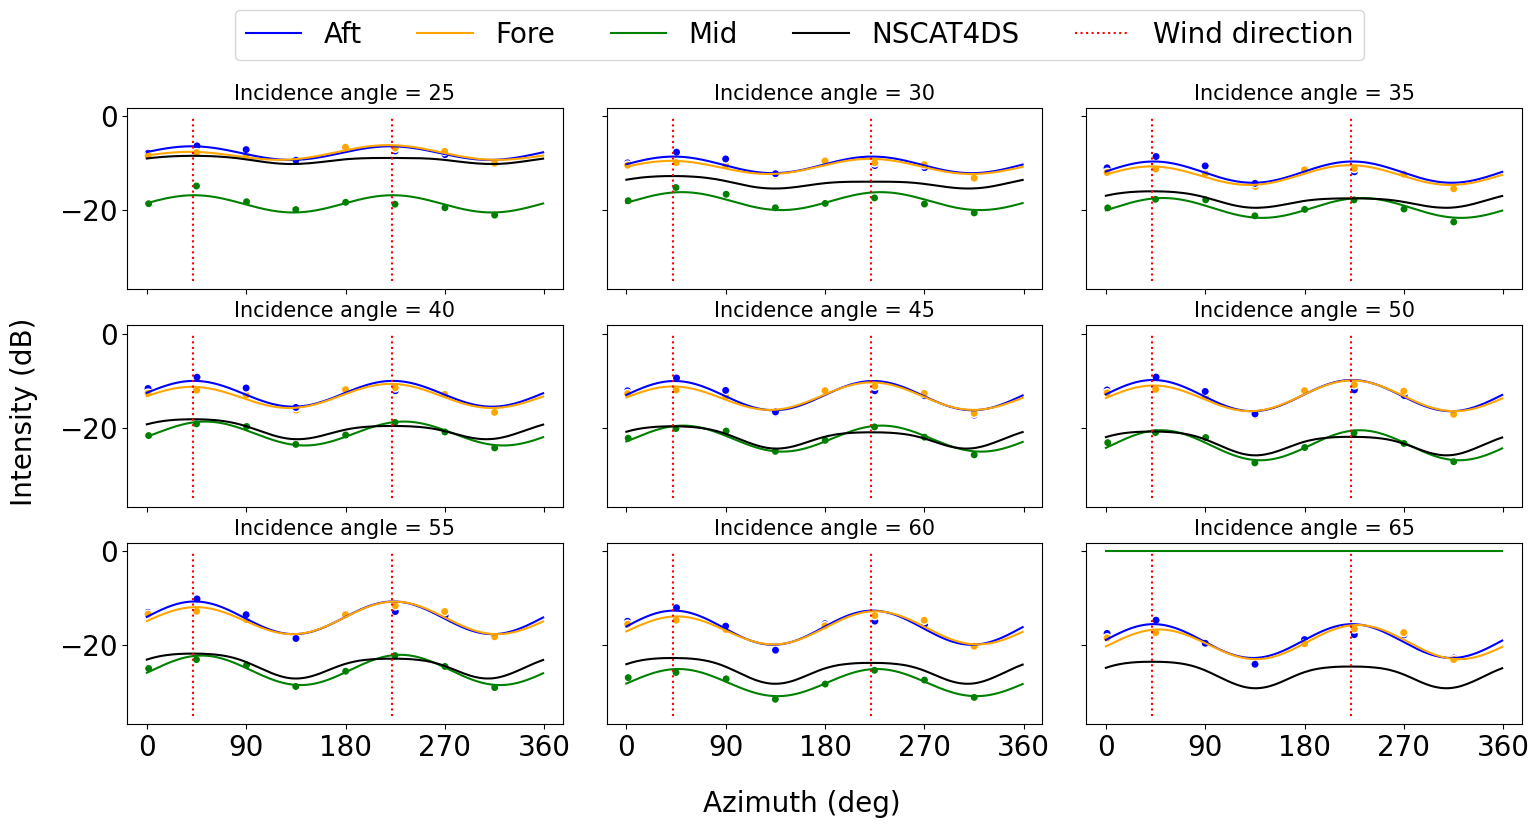

In [14]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True,
                        sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange','green']
ylim=[-35,0]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value)\
        .plot.scatter(x='azimuth',y='Intensity', hue='Antenna',ax=axs[ii], add_colorbar=False,
                     cmap=mpl.colors.ListedColormap(colors))
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Intensity_popt.data),
                 'blue', label='Aft')
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Intensity_popt.data),
                 'orange', label='Fore')
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Intensity_popt.data),
                 'green', label='Mid')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    # plot dummy curve
#     axs[ii].plot(az, fit_func_simple(az, -15, 0.1, 0.2, updir), '--k')
    # plot nscat
    ones = np.ones(np.size(az))
    nscat = 10*np.log10(
            ss.gmfs.nrcs.nscat4ds( 
                u10*ones,
                np.abs(np.mod(az - updir +180, 360) - 180),
                inci_value*ones,
                ones
            )
    )
    axs[ii].plot(az, nscat, 'k',label='NSCAT4DS')
    axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted')
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])          
fig.text(0.5, 0, 'Azimuth (deg)', ha='center')
fig.text(0.06, 0.5, 'Intensity (dB)', va='center', rotation='vertical')
handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5,bbox_to_anchor=(0.82,1.02))

# Coherence

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

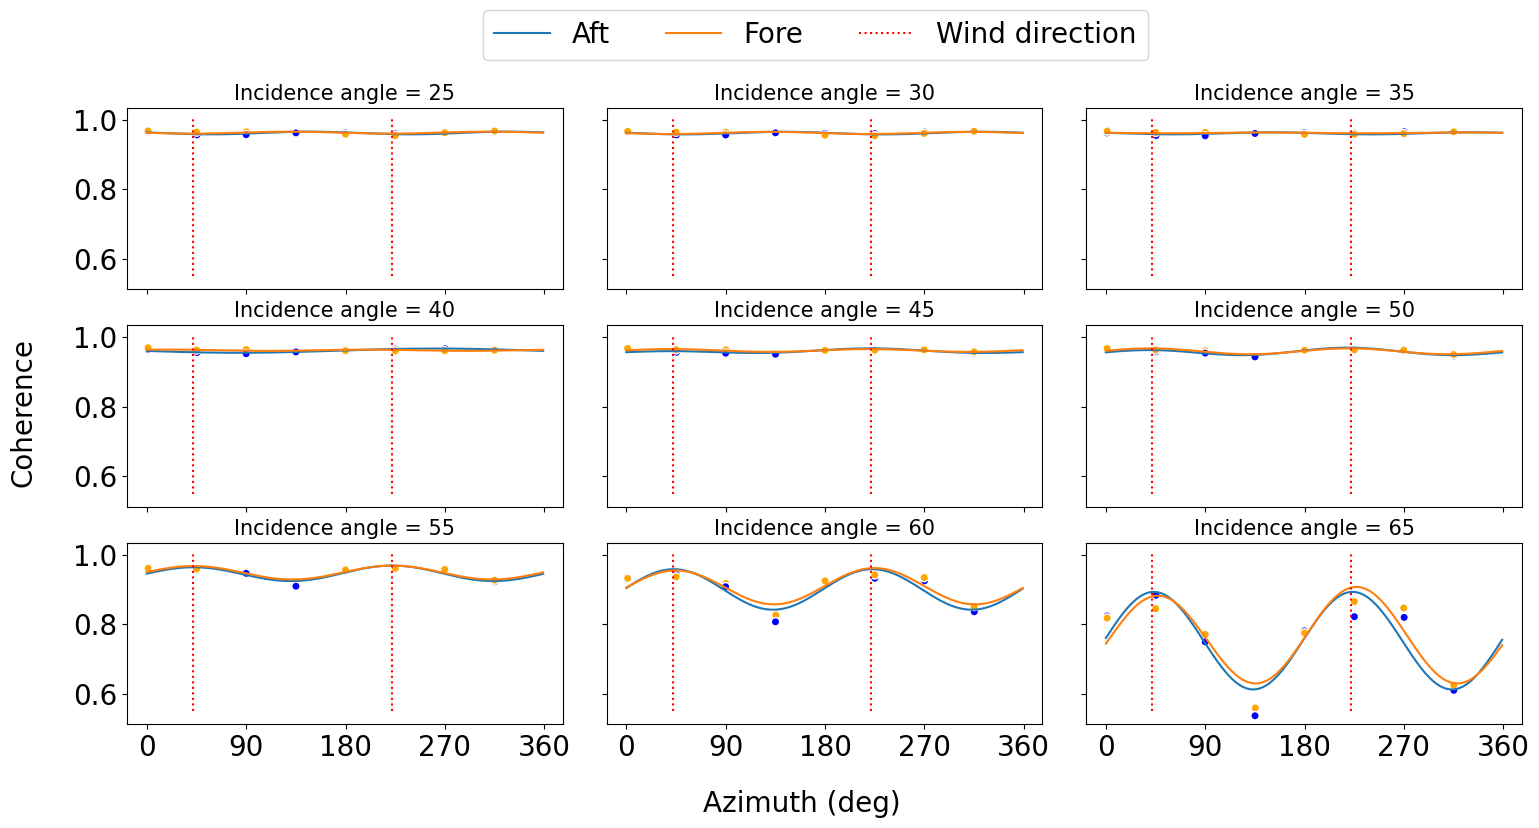

In [38]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']
ylim=[0.55,1.01]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='Coherence', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors))
#     axs[ii].plot(az,)
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Coherence_popt.data),
                 'C0',label='Aft')
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Coherence_popt.data),
                 'C1',label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted')  
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])          
fig.text(0.5, 0, 'Azimuth (deg)', ha='center')
fig.text(0.06, 0.5, 'Coherence', va='center', rotation='vertical')
handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3,bbox_to_anchor=(0.7,1.02))

# Interferogram

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

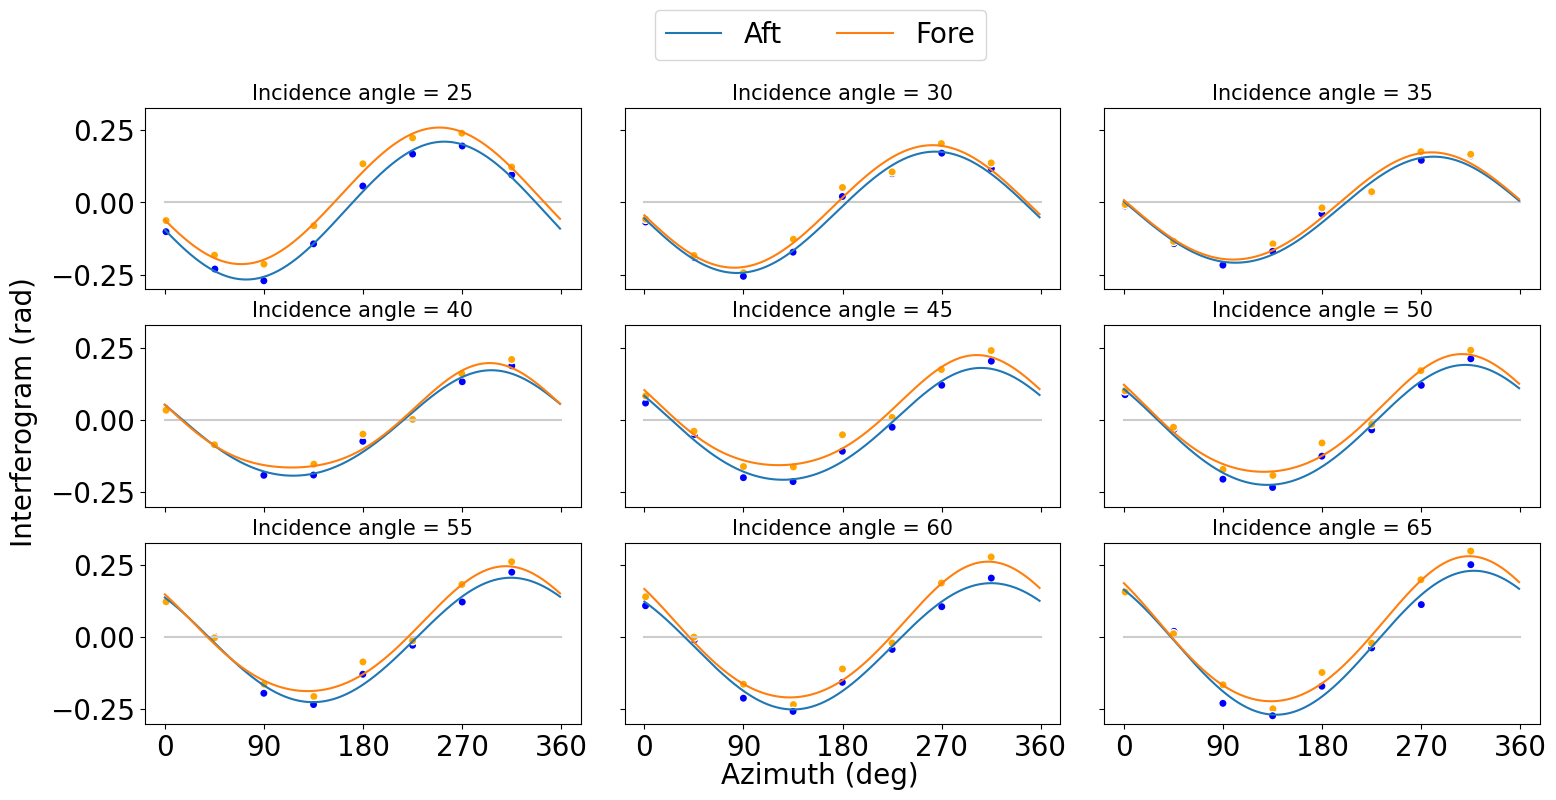

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']
ylim=[-0.28,0.28]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='Interferogram', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors),
                                         )

#     axs[ii].plot(az,)
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Aft', inci=inci_value).Interferogram_popt.data),
                 'C0', label='Aft')
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Fore', inci=inci_value).Interferogram_popt.data),
                 'C1', label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])          
fig.text(0.5, 0.035, 'Azimuth (deg)', ha='center')
fig.text(0.05, 0.5, 'Interferogram (rad)', va='center', rotation='vertical')

handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2,bbox_to_anchor=(0.6,1.02))
plt.savefig(fig_folder + 'Interferogram_landcalib.png', dpi=150, bbox_inches='tight')

# WASV

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

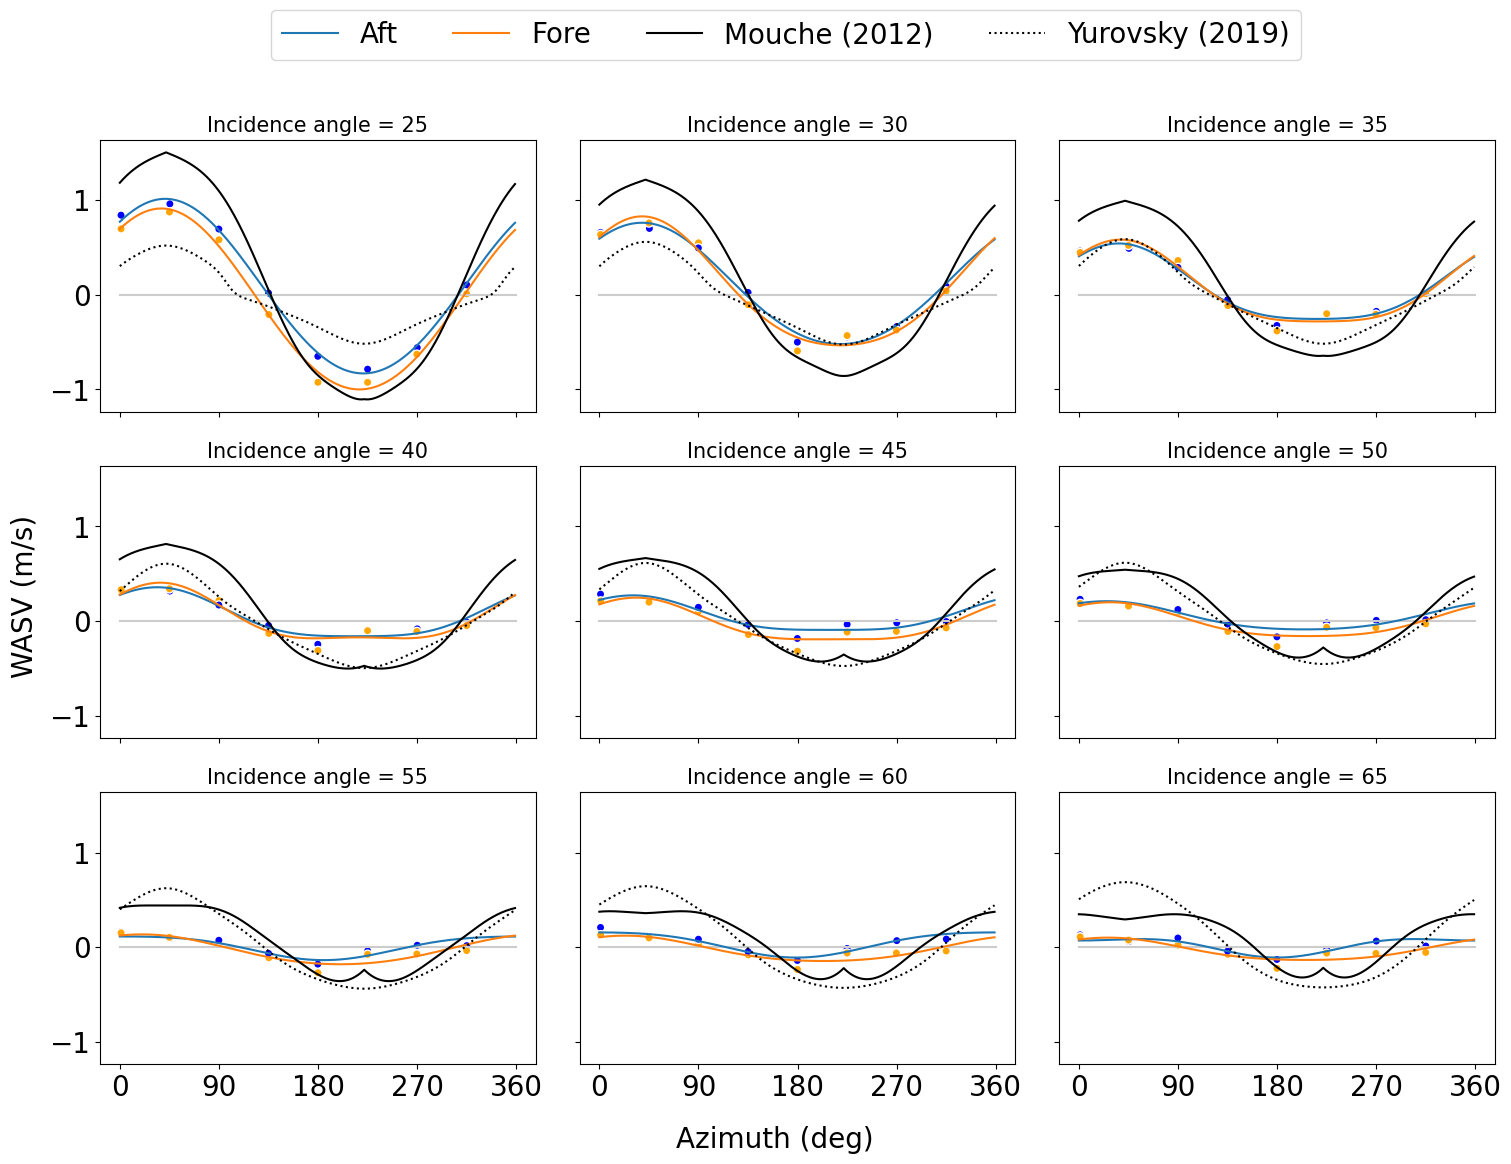

In [29]:
#---------Run ADCP Comparison to colocate ADCP data first---------------

ADCP = - np.mean(U_adcp) * np.cos(np.radians(az-np.mean(dir_adcp)))


fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']

ylim=[-1,1]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='WASV', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors),
                                         )
    
    
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Aft', inci=inci_value).WASV_popt.data),
                  'C0', label='Aft')
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Fore', inci=inci_value).WASV_popt.data),
                 'C1', label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
    dop_c = ss.gmfs.doppler.mouche12(u10*ones,
                                    np.abs(np.mod(az - updir +180, 360) - 180),
                                    inci_value*ones,
                                    'VV')
    f_c = 5.5 * 10 ** 9
    dop_Hz = dop_c * ds_L1b['Track_11'].CentralFreq.data[0] / f_c
    [wasv_losv, wasv_mouche12] = ss.gmfs.doppler.convertDoppler2Velocity(
                ds_L1b['Track_11'].CentralFreq.data[0] / 1e9,
                dop_Hz,
                inci_value*ones
            )
    axs[ii].plot(az, - wasv_mouche12, 'k', label='Mouche (2012)')
    [wasv_yurovsky, dc_HH] = ss.gmfs.doppler.yurovsky19(
            inci_value*ones,
            np.abs(np.mod(az - updir +180, 360) - 180),
            u10*ones,
            lambdar=(1 / ds_L1b['Track_11'].CentralFreq.data[0]) * sp.constants.c,
        )
    axs[ii].plot(az, - wasv_yurovsky, 'k',linestyle='dotted', label='Yurovsky (2019)')
    #axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    #axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted') 
    #axs[ii].plot([np.mean(dir_adcp), np.mean(dir_adcp)], ylim, 'purple',linestyle='dotted')
    #axs[ii].plot(az, ADCP, 'purple', label='ADCP')
    
fig.text(0.5, 0.04, 'Azimuth (deg)', ha='center')
fig.text(0.075, 0.5, 'WASV (m/s)', va='center', rotation='vertical')

handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4,bbox_to_anchor=(0.8,1.0))
plt.savefig(fig_folder + 'WASV_landcalib.png', dpi=150, bbox_inches='tight')

# Radial Surface Current - Yurovsky (2019)

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

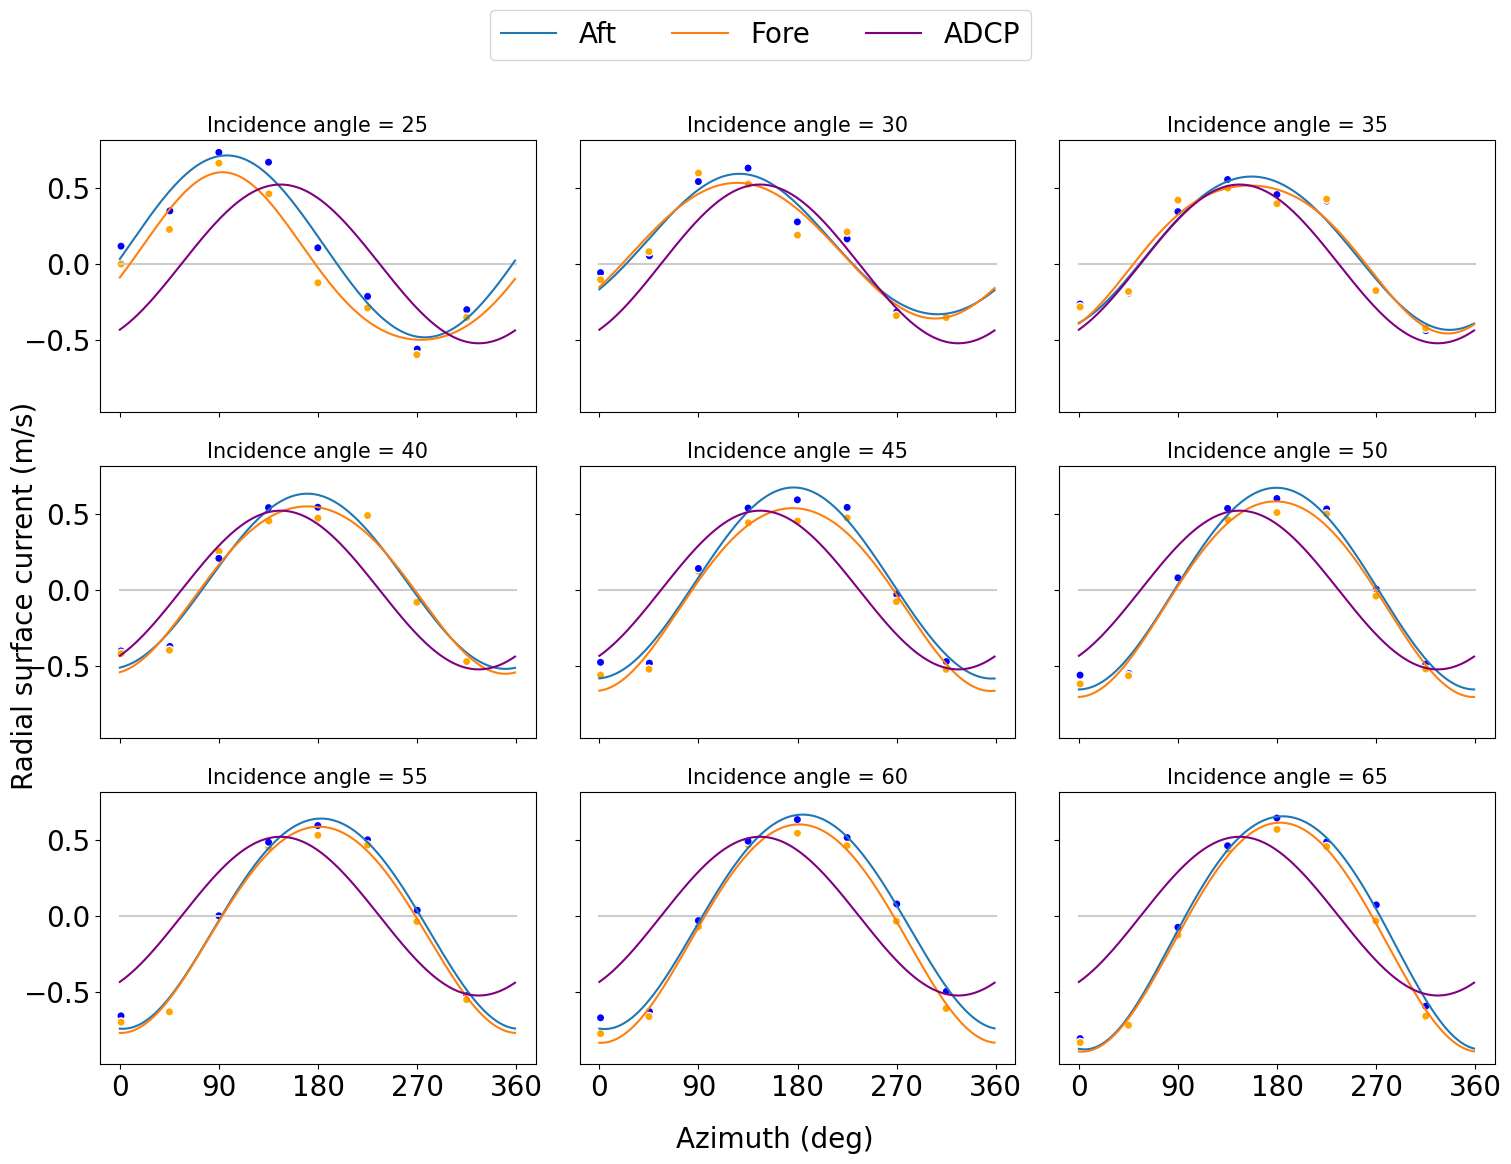

In [31]:
#---------Run ADCP Comparison to colocate ADCP data first---------------

ADCP = - np.mean(U_adcp) * np.cos(np.radians(az-np.mean(dir_adcp)))

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']

ylim=[-1,1]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='RadialSurfaceCurrent_yurovsky19', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors),
                                         )
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Aft', inci=inci_value).RSC_yurovsky_popt.data),
                  'C0', label='Aft')
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Fore', inci=inci_value).RSC_yurovsky_popt.data),
                 'C1', label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
#     dop_c = ss.gmfs.doppler.mouche12(u10*ones,
#                                     np.abs(np.mod(az - updir +180, 360) - 180),
#                                     inci_value*ones,
#                                     'VV')
#     f_c = 5.5 * 10 ** 9
#     dop_Hz = dop_c * ds_L1b['Track_11'].CentralFreq.data[0] / f_c
#     [wasv_losv, wasv_mouche12] = ss.gmfs.doppler.convertDoppler2Velocity(
#                 ds_L1b['Track_11'].CentralFreq.data[0] / 1e9,
#                 dop_Hz,
#                 inci_value*ones
#             )
#     axs[ii].plot(az, wasv_mouche12, 'k', label='Mouche12')
    [wasv_yurovsky, dc_HH] = ss.gmfs.doppler.yurovsky19(
            inci_value*ones,
            np.abs(np.mod(az - updir +180, 360) - 180),
            u10*ones,
            lambdar=(1 / ds_L1b['Track_11'].CentralFreq.data[0]) * sp.constants.c,
        )
    
    #axs[ii].plot(az, rsc, 'purple', label='ADCP')
    
    #axs[ii].plot(az, wasv_yurovsky, 'k', label='WASV Yurovsky')
    #axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    #axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted') 
    #axs[ii].plot([np.mean(dir_adcp), np.mean(dir_adcp)], ylim, 'purple',linestyle='dotted')
    axs[ii].plot(az, ADCP, 'purple', label='ADCP')
    

fig.text(0.5, 0.04, 'Azimuth (deg)', ha='center')
fig.text(0.075, 0.5, 'Radial surface current (m/s)', va='center', rotation='vertical')

handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=6,bbox_to_anchor=(0.65,1.0))
plt.savefig(fig_folder + 'RSC_yurovsky19_landcalib.png', dpi=150, bbox_inches='tight')

# Radial Surface Current - Mouche (2012)

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: 

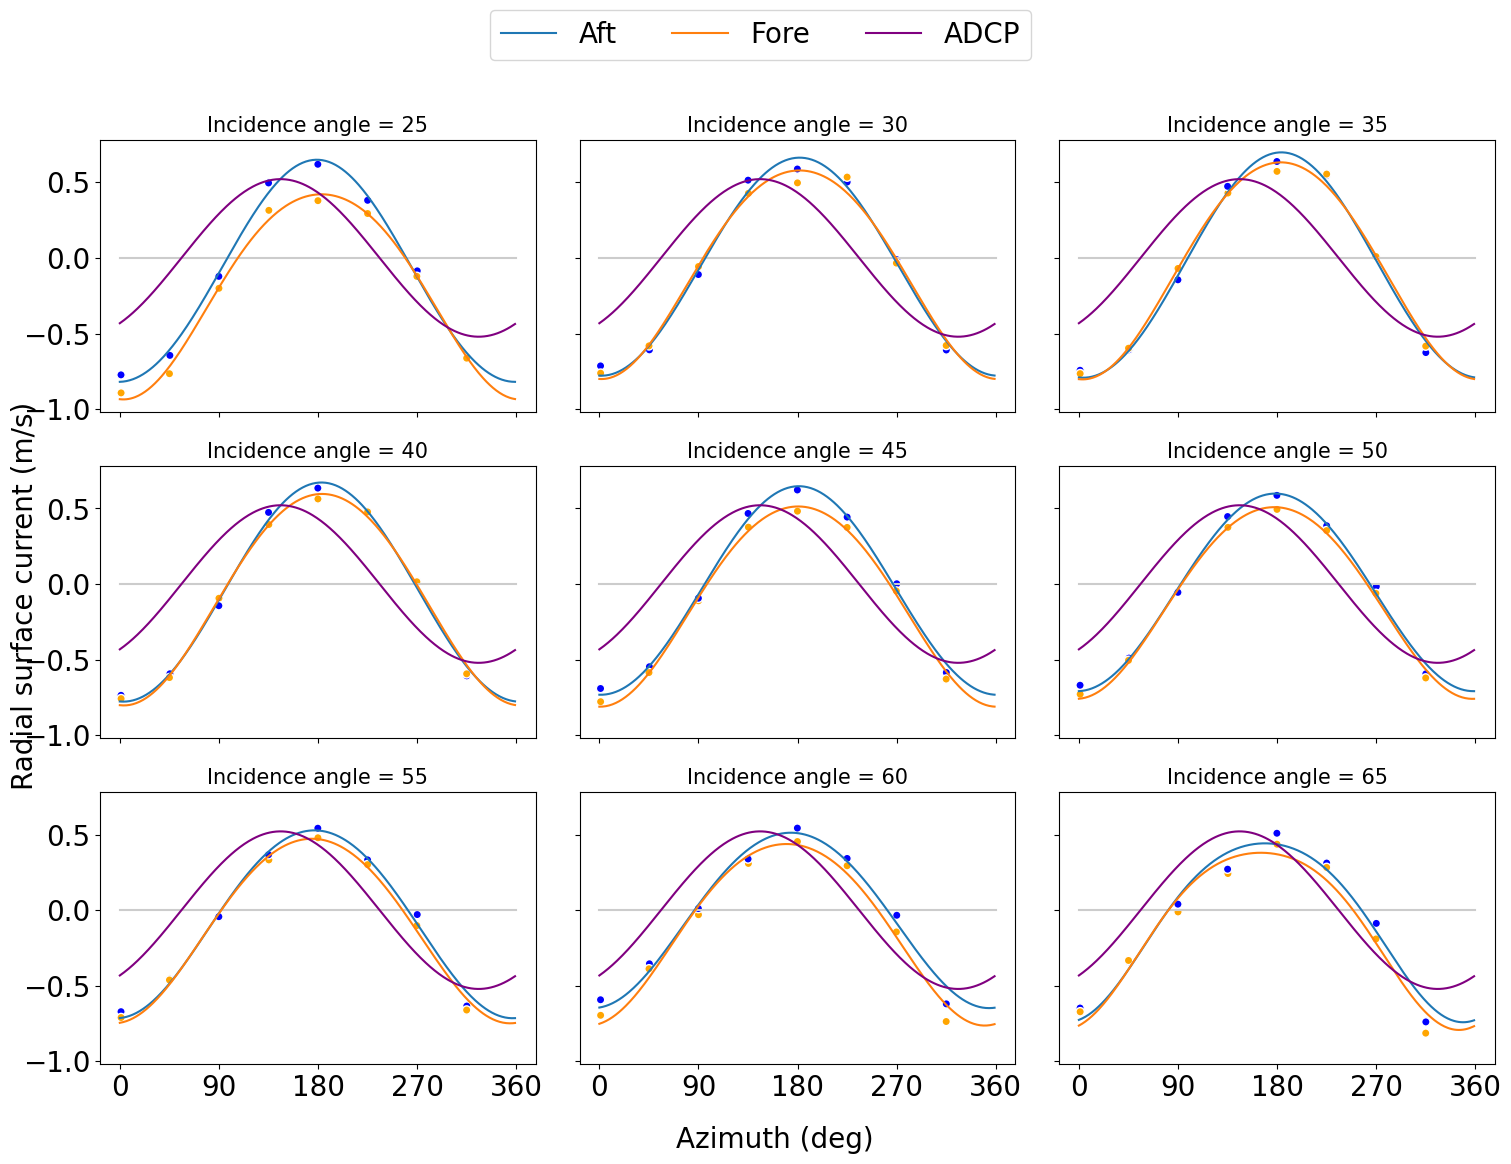

In [33]:
#---------Run ADCP Comparison to colocate ADCP data first---------------

ADCP = - np.mean(U_adcp) * np.cos(np.radians(az-np.mean(dir_adcp)))

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']

ylim=[-1,1]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='RadialSurfaceCurrent_mouche12', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors),
                                         )
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Aft', inci=inci_value).RSC_mouche_popt.data),
                  'C0', label='Aft')
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Fore', inci=inci_value).RSC_mouche_popt.data),
                 'C1', label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
    dop_c = ss.gmfs.doppler.mouche12(u10*ones,
                                    np.abs(np.mod(az - updir +180, 360) - 180),
                                    inci_value*ones,
                                    'VV')
    f_c = 5.5 * 10 ** 9
    dop_Hz = dop_c * ds_L1b['Track_11'].CentralFreq.data[0] / f_c
    [wasv_losv, wasv_mouche12] = ss.gmfs.doppler.convertDoppler2Velocity(
                ds_L1b['Track_11'].CentralFreq.data[0] / 1e9,
                dop_Hz,
                inci_value*ones
            )
    #axs[ii].plot(az, wasv_mouche12, 'k', label='WASV Mouche12')
#     [wasv_yurovsky, dc_HH] = ss.gmfs.doppler.yurovsky19(
#             inci_value*ones,
#             np.abs(np.mod(az - updir +180, 360) - 180),
#             u10*ones,
#             lambdar=(1 / ds_L1b['Track_11'].CentralFreq.data[0]) * sp.constants.c,
#         )
    
    #axs[ii].plot(az, rsc, 'purple', label='ADCP')
    
#     axs[ii].plot(az, wasv_yurovsky, 'k', label='WASV Yurovsky')
    #axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    #axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted') 
    #axs[ii].plot([np.mean(dir_adcp), np.mean(dir_adcp)], ylim, 'purple',linestyle='dotted')
    axs[ii].plot(az, ADCP, 'purple', label='ADCP')
    
    
fig.text(0.5, 0.04, 'Azimuth (deg)', ha='center')
fig.text(0.075, 0.5, 'Radial surface current (m/s)', va='center', rotation='vertical')

handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=6,bbox_to_anchor=(0.65,1.0))
plt.savefig(fig_folder + 'RSC_mouche12_landcalib.png', dpi=150, bbox_inches='tight')

In [329]:
updir

42

(5.0, 15.0)

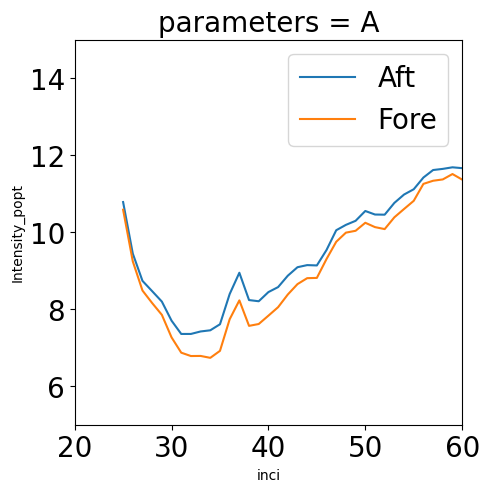

In [114]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
IA = fit.Intensity_popt.sel(parameters='A')
(IA.sel(Antenna='Aft') - IA.sel(Antenna='Mid')).plot(label='Aft')
(IA.sel(Antenna='Fore') - IA.sel(Antenna='Mid')).plot(label='Fore')
plt.legend()
#plt.xticks[20,30,40,50,60]
plt.xlim([20,60])
plt.ylim([5,15])

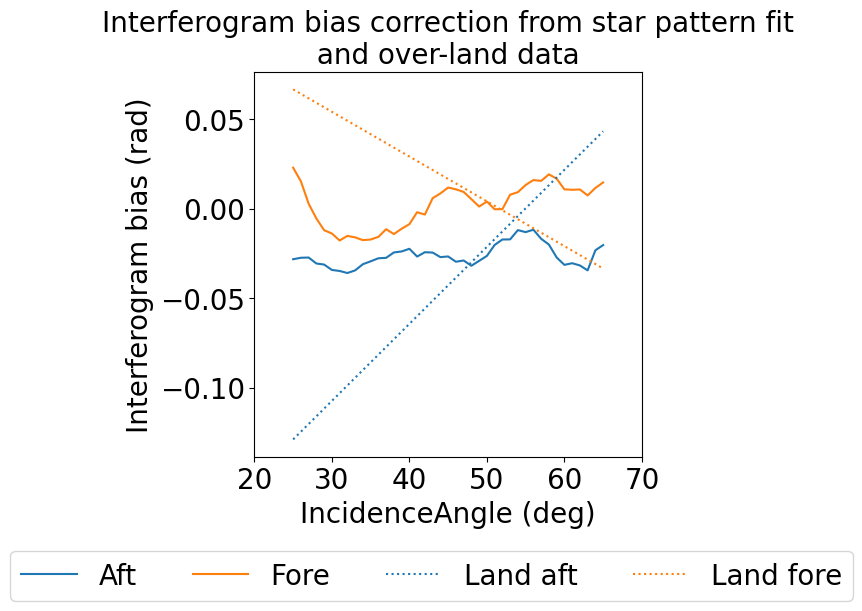

In [34]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
IA = fit.Interferogram_popt.sel(parameters='A')
(IA.sel(Antenna='Aft') - IA.sel(Antenna='Mid')).plot(label='Aft')
(IA.sel(Antenna='Fore') - IA.sel(Antenna='Mid')).plot(label='Fore')
(0.0043 * IA.sel(Antenna='Aft').inci + -0.2364).plot(label='Land aft', color='C0', linestyle='dotted')
(-0.0025 * IA.sel(Antenna='Fore').inci + 0.129).plot(label='Land fore', color='C1', linestyle='dotted')


plt.xlabel('IncidenceAngle (deg)',fontsize=20)
plt.ylabel('Interferogram bias (rad)',fontsize=20)
plt.title('Interferogram bias correction from star pattern fit\n and over-land data ')
plt.xticks([20,30,40,50,60,70])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,ncol=4,bbox_to_anchor=(1.35,-0.05))
# plt.savefig(fig_folder + 'Interferogram_bias_starpattern_land.png', dpi=150, bbox_inches='tight')

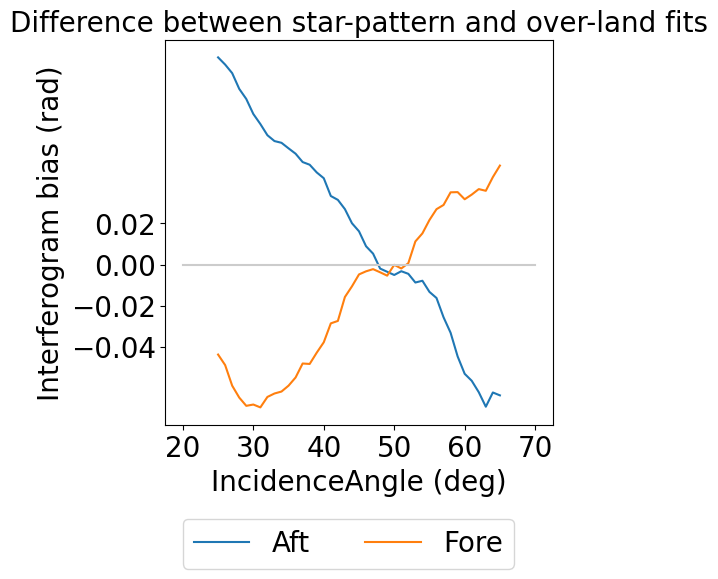

In [35]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
IA = fit.Interferogram_popt.sel(parameters='A')
((IA.sel(Antenna='Aft') - IA.sel(Antenna='Mid')) - (0.0043 * IA.sel(Antenna='Aft').inci + -0.2364)).plot(label='Aft')
((IA.sel(Antenna='Fore') - IA.sel(Antenna='Mid')) - (-0.0025 * IA.sel(Antenna='Fore').inci + 0.129)).plot(label='Fore')
plt.plot([20,70],[0,0],c=[0.8,0.8,0.8])


plt.xlabel('IncidenceAngle (deg)',fontsize=20)
plt.ylabel('Interferogram bias (rad)',fontsize=20)
plt.title('Difference between star-pattern and over-land fits')
plt.xticks([20,30,40,50,60,70])
plt.yticks([-0.04,-0.02,0,0.02])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,ncol=4,bbox_to_anchor=(0.85,-0.05))
# plt.savefig(fig_folder + 'Interferogram_bias_starpattern_minus_land.png', dpi=150, bbox_inches='tight')

In [57]:
IA.to_netcdf('D:\\data\\SEASTAR\\SEASTARex\\Data\\calib\\star_pattern_interferogram_calib.nc')

Text(0, 0.5, 'Retrieved current velocity (m/s)')

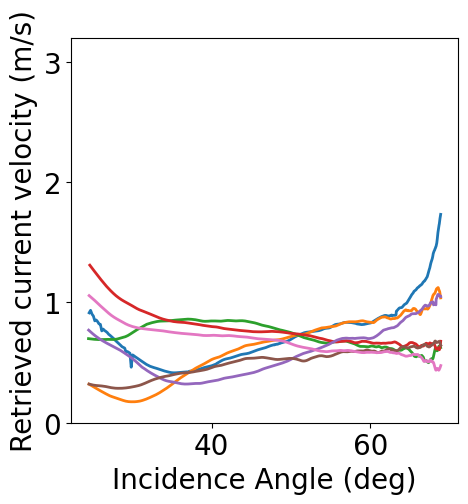

In [104]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
for track in ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17']:
    plt.plot(ds_L1b[track].IncidenceAngleImage.sel(Antenna='Fore').mean(dim='CrossRange'),
             ds_L2[track].CurrentVelocity.mean(dim='CrossRange'),
            linewidth=2)
    ax.set_ylim([0,3.2])
plt.xlabel('Incidence Angle (deg)', fontsize=20)
plt.ylabel('Retrieved current velocity (m/s)', fontsize=20)

Text(0.5, 1.0, 'Star pattern currents\n 20220522')

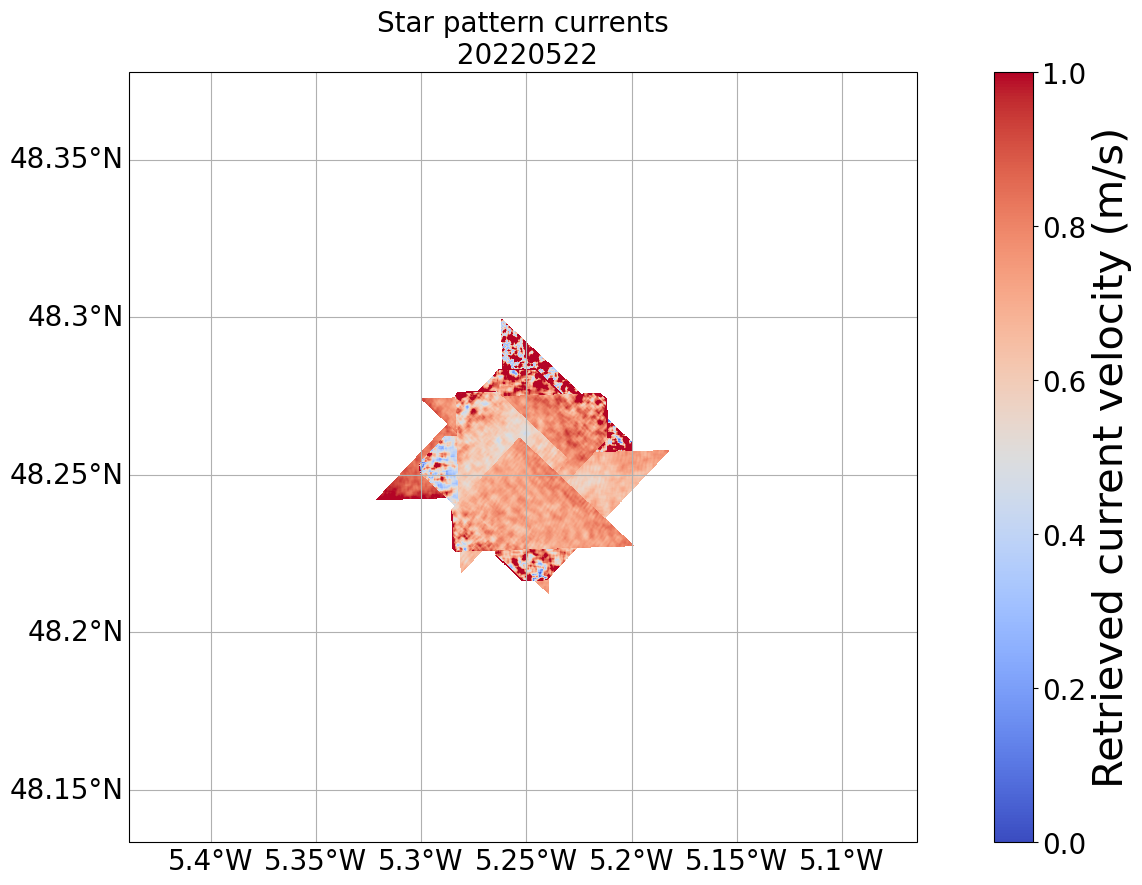

In [37]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())

for track in ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17']:
    im=ds_L2[track].CurrentVelocity.plot(x='longitude', y='latitude',
      transform=ccrs.PlateCarree(),
                                      cmap='coolwarm',
                                         vmin=0, vmax=1,
    add_colorbar=False,)
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
#ax.set_extent([-6, -4.6, 47.6, 48.9], crs=ccrs.PlateCarree()) # Wide plot
#ax.set_extent([-5.2, -5.025, 48.37, 48.52], crs=ccrs.PlateCarree()) # Ushant
#ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)

cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Retrieved current velocity (m/s)',fontsize=30)
plt.title('Star pattern currents\n 20220522')

In [37]:
def nearest_coord2D(x, y, xi, yi):
    abs_y = np.abs(y-yi)
    abs_x = np.abs(x-xi)
    c = np.maximum(abs_x, abs_y)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    return xloc, yloc

# Colocate HF and Star Pattern data

In [38]:
U_oscar = []
U_HF = []
t = ds_L2['Track_11'].TrackTime
bounds = [-5.35, -5.25, 48.2, 48.31]
m,n = aux_list['HF_combined'].latitude.shape
for i in range(m):
    for j in range(n):
        if (bounds[0] <= aux_list['HF_combined'].longitude[i, j] <= bounds[1]):
            if (bounds[2] <= aux_list['HF_combined'].latitude[i, j] <= bounds[3]):
                
                for track in L1.Track.values:
                    t = ds_L2['Track_' + str(11)].TrackTime
                    xloc, yloc = nearest_coord2D(x=L1.sel(Track=11).longitude.values,
                                                 y=L1.sel(Track=11).latitude.values,
                                                 xi=aux_list['HF_combined'].longitude[i, j].values,
                                                 yi=aux_list['HF_combined'].latitude[i, j].values,
                                                )
                    
                    CurrentVelocity = np.sqrt(L1.sel(Track=track, Antenna='Fore')
                                .RadialSurfaceCurrent_yurovsky19 **2 +
                                L1.sel(Track=track, Antenna='Aft')
                                .RadialSurfaceCurrent_yurovsky19 **2)
                    U_oscar = np.append(U_oscar,
                                       CurrentVelocity.values[xloc, yloc])
                                        
                    U_HF =np.append(U_HF,
                                    aux_list['HF_combined']
                                    .sel(time=t, method='nearest')
                                    .CurrentVelocity.data[i,j],
                                   )


(0.2, 0.9)

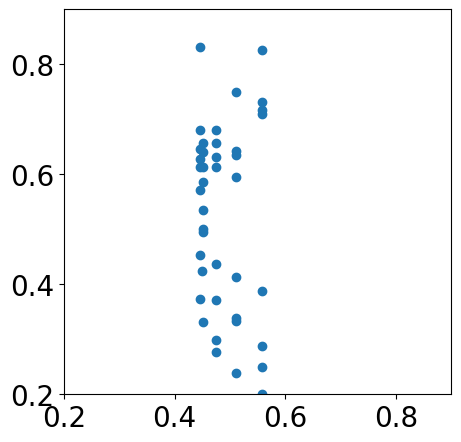

In [39]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
plt.scatter(U_HF, U_oscar)
plt.xlim([0.2,0.9])
plt.ylim([0.2,0.9])

# ADCP comparison

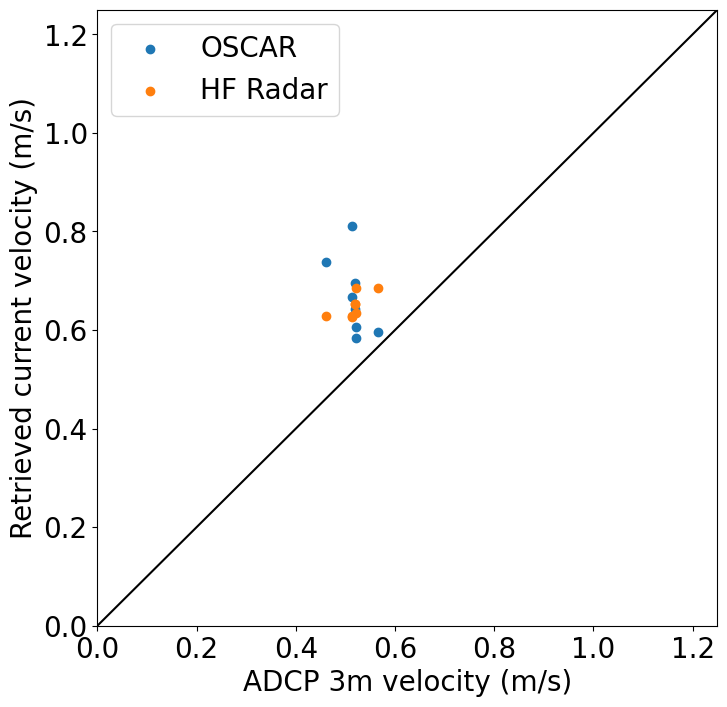

In [51]:


plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)

HF_effective_depth = sp.constants.c * (1 / 7.8e06) / (8 * np.pi) # 7.8MHz HF frequency

lon=aux_list['Trefle'].longitude.mean().data
lat=aux_list['Trefle'].latitude.mean().data
U_oscar=np.empty(0)

U_adcp=np.empty(0)
dir_adcp=np.empty(0)
U_HF=np.empty(0)
tracks=[];
for i in range(11,18 + 1):
    track = 'Track_' + str(i)
    tracks.append(track)
# First, find the index of the grid point nearest a specific lat/lon.
    abslat = np.abs(ds_L2[track].latitude-lat)
    abslon = np.abs(ds_L2[track].longitude-lon)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    
    U_oscar = np.append(U_oscar,
                        ds_L2[track].CurrentVelocity\
                        .coarsen(GroundRange=c_factor,boundary='trim').mean()\
                        .coarsen(CrossRange=c_factor,boundary='trim').mean()\
                        .sel(CrossRange=ds_L2[track].CrossRange[xloc],
                                  GroundRange=ds_L2[track].GroundRange[yloc],
                            method='nearest'))

    t = ds_L2[track].TrackTime
#     U_adcp = np.append(U_adcp,
#                        np.sqrt(aux_list['Trefle'].v_e.sel(time=t, method='nearest').isel(bin=0) ** 2\
#                                + aux_list['Trefle'].v_n.sel(time=t, method='nearest').isel(bin=0) ** 2
#                               )
#                       )
    vel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['Trefle'].v_e.sel(time=t, method='nearest').isel(bin=0),
                                 aux_list['Trefle'].v_n.sel(time=t, method='nearest').isel(bin=0))
    U_adcp = np.append(U_adcp, vel)
    dir_adcp = np.append(dir_adcp, cdir)
    
    abslat = np.abs(aux_list['HF_combined'].latitude-lat)
    abslon = np.abs(aux_list['HF_combined'].longitude-lon)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    U_HF = np.append(U_HF, aux_list['HF_combined'].CurrentVelocity.isel(lat=yloc,lon=xloc)\
                       .sel(time=t, method='nearest')
                    )
x_max=1.25
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
plt.scatter(U_adcp, U_oscar,label='OSCAR')
plt.scatter(U_adcp, U_HF,label='HF Radar')
plt.xlim([0,x_max])
plt.ylim([0,x_max])
plt.plot([0,x_max],[0,x_max],'k')
plt.xlabel('ADCP 3m velocity (m/s)', fontsize=20)
plt.ylabel('Retrieved current velocity (m/s)', fontsize=20)
plt.legend()
plt.show()




In [49]:
print('RMS Error between OSCAR and HF radar over Trefle buoy = ',str(np.round(
    np.sqrt(np.nanmean(U_oscar - U_HF) **2 ),3)),'m/s')
print('RMS Error between OSCAR and ADCP = ',str(np.round(
    np.sqrt(np.nanmean(U_oscar - U_adcp) **2 ),3)),'m/s')

RMS Error between OSCAR and HF radar over Trefle buoy =  0.018 m/s
RMS Error between OSCAR and ADCP =  0.15 m/s


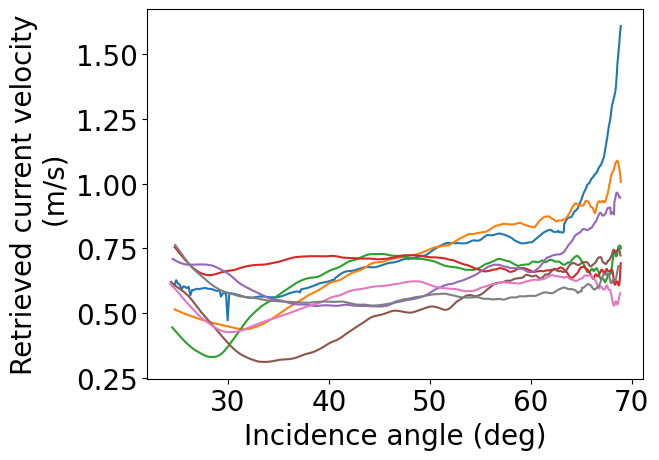

In [50]:

# all_star_tracks_list = ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17']
# all_track_list = [11, 12, 13, 14, 15, 16, 17]
# dsl2 = [None] * len(all_star_tracks_list)
# for ii, track in enumerate(all_star_tracks_list):
#     dsl2[ii] = ds_L2[track].CurrentVelocity
# #    dsl2[ii]['AntennaAzimuthImage'] = ds_L1b[track].AntennaAzimuthImage.sel(Antenna='Fore')
#     dsl2[ii]['IncidenceAngleImage'] = ds_L1b[track].IncidenceAngleImage.sel(Antenna='Fore')
# # #      = ds.set_coords(coords_list)

# L2 = xr.concat(dsl2, dim='Track')
# L2['Track'] = all_track_list



for track in ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17','Track_18']:
    plt.plot(ds_L1b[track].IncidenceAngleImage.sel(Antenna='Fore').sel(CrossRange=0, method='nearest'),
         ds_L2[track].CurrentVelocity.mean(dim='CrossRange'))

plt.xlabel('Incidence angle (deg)', fontsize=20)
plt.ylabel('Retrieved current velocity\n (m/s)', fontsize=20)
# plt.title('Mean current velocity in the CrossRange direction\n vs Incidence Angle of the Fore beam \n'+
#          'Line colours denote tracks in the star pattern')
#ds_L1b['Track_11'].IncidenceAngleImage.sel(Antenna='Fore').sel(CrossRange=0, method='nearest').plot()
plt.show()


In [ ]:
quivers=False

for track in ds_L2.keys():
    tracktime = str(np.datetime64(ds_L2[track].TrackTime.data,'m'))
    # Plot current magnitude with u,v vectors overlain, geographic coordinates
    plot_pixel_size = 200 #pixel size in metres
    sar_pixel_size = 8
    c_factor_image = int(plot_pixel_size / sar_pixel_size)
    #c_factor = 1 # Coarsening factor
    q_factor = 30 # Quiver plot scaling factor
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
    im=ds_L2[track]\
    .coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
    .coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
    .CurrentVelocity.plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
    if quivers:
        ds_L2[track]\
        .coarsen(GroundRange=q_factor,boundary='trim').mean()\
        .coarsen(CrossRange=q_factor,boundary='trim').mean()\
        .plot.quiver(
            x='longitude',
            y='latitude',
            u='CurrentVectorUComponent',
            v='CurrentVectorVComponent',
            scale=50,
            angles='xy',
            robust=True,
            transform=ccrs.PlateCarree()
        )
        
    #plt.title(ds_L1b[track].attrs['Title'])
    gl=ax.gridlines(draw_labels=False)
    gl.top_labels=False
    gl.right_labels=False
    
    gl.bottom_labels=False
    gl.left_labels=False
    
    #ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
    #with warnings.catch_warnings():
    #    warnings.simplefilter("ignore", category=Warning)
    #ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    
    #cbar = plt.colorbar(im)
    #cbar.set_label('RSC velocity (m/s)',fontsize=30)
    
    #plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=2)
    #plt.show()



In [ ]:
Trefle = xr.open_dataset(local_paths['aux_path'] + folder + 'Trefle_MLM.nc')
GL1 = xr.open_dataset(local_paths['aux_path'] + folder + 'GL_TS_MO_6200001.nc')

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


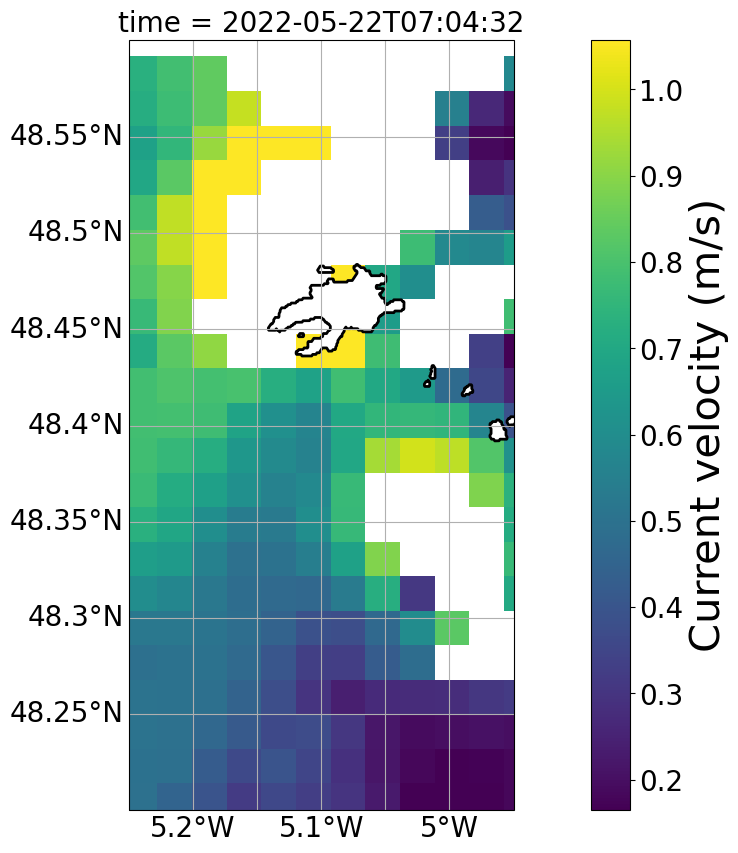

In [97]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im = aux_list['HF_combined'].CurrentVelocity\
                            .sel(time=ds_L2[track].TrackTime,method='nearest')\
                            .plot(x='longitude',y='latitude',
                            robust=True, 
                            #cmap='coolwarm',
                            #vmin=0, vmax=3,
                            transform=ccrs.PlateCarree(),
                            add_colorbar=False,
                                 )
#ax.set_extent([-5.7, -4, 47.5, 48.7], crs=ccrs.PlateCarree())
ax.set_extent([-5.25, -4.95, 48.2, 48.6], crs=ccrs.PlateCarree())
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=Warning)
    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
cbar = plt.colorbar(im)
cbar.set_label('Current velocity (m/s)',fontsize=30)
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Solve HF Brezellec radials

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


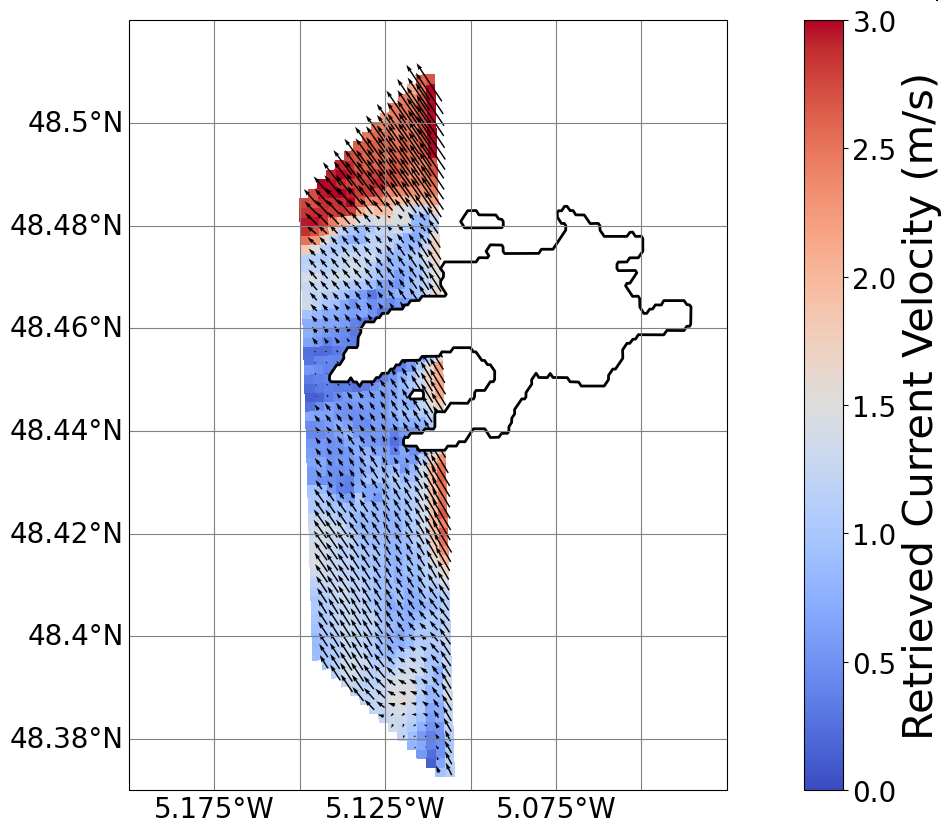

In [87]:
unit_radials=xr.Dataset()
dlat = aux_list['HF_radial'].Site_latitude - ds_L2['Track_1'].latitude
dlon = aux_list['HF_radial'].Site_longitude - ds_L2['Track_1'].longitude
dist = np.sqrt(dlon **2 + dlat **2)
unit_lon = dlon / dist
unit_lat = dlat / dist
unit_radials['U_corrected'] = unit_lon * ds_L2['Track_1'].CurrentVectorUComponent + unit_lat * ds_L2['Track_1'].CurrentVectorVComponent
unit_radials['V_corrected'] = unit_lat * ds_L2['Track_1'].CurrentVectorUComponent + unit_lon * ds_L2['Track_1'].CurrentVectorVComponent
# lat = aux_list['HF_radial'].Site_latitude
# lon = aux_list['HF_radial'].Site_longitude
# unit_vector = [np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)]
# dot_product = (ds_L2['Track_1'].CurrentVectorUComponent * unit_vector[0]
#               +ds_L2['Track_1'].CurrentVectorVComponent * unit_vector[1])

# unit_radials=xr.Dataset()
# unit_radials['U_corrected'] = dot_product * unit_vector[0]
# unit_radials['V_corrected'] = dot_product * unit_vector[1]
unit_radials['cdir'] = np.sqrt(unit_radials.U_corrected **2 + unit_radials.V_corrected **2)

# radial_dist, radial_dir = ss.utils.tools.windUV2SpeedDir(ds_L2['Track_1'].longitude - aux_list['HF_radial'].Site_longitude,
#                                                          ds_L2['Track_1'].latitude - aux_list['HF_radial'].Site_latitude)

# radial_dir=xr.DataArray(data=np.mod(radial_dir-180, 360),
#                        coords=radial_dist.coords,
#                        dims=radial_dist.dims)
# radial_unitU, radial_unitV = ss.utils.tools.windSpeedDir2UV(np.full(radial_dist.shape,1), radial_dir)
# unit_radials = xr.Dataset()
# unit_radials['U'] = radial_unitU
# unit_radials['V'] = radial_unitV
# cvel, cdir = ss.utils.tools.currentUV2VelDir(ds_L2['Track_1'].CurrentVectorUComponent
#                                                                              - unit_radials.U,
#                                                                              ds_L2['Track_1'].CurrentVectorVComponent
#                                                                             - unit_radials.V)
# unit_radials['cvel'] = cvel
# unit_radials['cdir'] = xr.DataArray(data=cdir, coords=cvel.coords, dims=cvel.dims)
# unit_radials['U_corrected'], unit_radials['V_corrected'] = ss.utils.tools.currentVelDir2UV(unit_radials.cvel,
#                                                                                           unit_radials.cdir)

# unit_radials['U_corrected'] = xr.DataArray(data=np.dot(ds_L2['Track_1'].CurrentVectorUComponent, unit_radials.U.T).T,
#                                            coords=unit_radials.coords,
#                                            dims=unit_radials.dims)
# unit_radials['V_corrected'] = xr.DataArray(np.dot(ds_L2['Track_1'].CurrentVectorUComponent, unit_radials.U.T).Y,
#                                            coords=unit_radials.coords,
#                                            dims=unit_radials.dims)

# cvel, cdir = ss.utils.tools.currentUV2VelDir(unit_radials.U_corrected, unit_radials.V_corrected)
# unit_radials['cvel'] = cvel
# unit_radials['cdir'] = xr.DataArray(data=cdir, coords=cvel.coords, dims=cvel.dims)


track='Track_1'
tracktime = str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor_image = int(plot_pixel_size / sar_pixel_size)
q_factor = 30 # Quiver plot scaling factor
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator(), frameon=True)
im=unit_radials\
.coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
.coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
.cvel\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
unit_radials\
.coarsen(GroundRange=q_factor,boundary='trim').mean()\
.coarsen(CrossRange=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='U_corrected',
    v='V_corrected',
    scale=50,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
gl=ax.gridlines(draw_labels=True, color='gray')
gl.top_labels=False
gl.right_labels=False
ax.set_extent([-5.2, -5.025, 48.37, 48.52], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
cbar = plt.colorbar(im)
cbar.set_label('Retrieved Current Velocity (m/s)',fontsize=30)


# q_factor = 200 
# unit_radials\
# .coarsen(GroundRange=q_factor,boundary='trim').mean()\
# .coarsen(CrossRange=q_factor,boundary='trim').mean()\
# .plot.quiver(x='longitude', y='latitude', u='U', v='V', scale=10, angles='xy', robust=True)
# plt.scatter(aux_list['HF_radial'].Site_longitude, aux_list['HF_radial'].Site_latitude)

In [ ]:


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im = aux_list['HF_radial'].U\
                            .sel(time=ds_L2[track].TrackTime,method='nearest')\
                            .plot(x='longitude',y='latitude',
                            robust=True, 
                            #cmap='coolwarm',
                            #vmin=0, vmax=3,
                            transform=ccrs.PlateCarree(),
                            add_colorbar=False,
                                 )
ax.set_extent([-5.7, -4, 47.5, 48.7], crs=ccrs.PlateCarree())

In [ ]:
latitude, longitude = np.meshgrid(aux_list['HF_combined'].latitude.data, aux_list['HF_combined'].longitude.data)
aux_list['HF_combined'].latitude

In [ ]:

aux_list['HF_radial'].isel(
    time=np.argmin(np.abs(aux_list['HF_radial'].time - ds_L2[track].TrackTime),keepdims=True).data
).U.plot(x='longitude',y='latitude')




In [ ]:
np.sqrt(aux_list['Trefle'].v_e.sel(time=ds_L2[track].TrackTime,method='nearest').isel(bin=0).data ** 2
 + aux_list['Trefle'].v_n.sel(time=ds_L2[track].TrackTime,method='nearest').isel(bin=0).data ** 2)

In [ ]:
mask = ss.utils.tools.compute_land_mask_from_GSHHS(ds_L1b[track].Interferogram.sel(Antenna='Mid'),
                                                        skip=1/1000)
mask.plot(x='CrossRange',y='GroundRange')

In [32]:
def oscar_plot(im_dataset, im_var, figsize=(20, 10), plot_pixel_size=200, quivers=False, q_factor=30, u='',v=''):
    sar_pixel_size = 8
    c_factor_image = int(plot_pixel_size / sar_pixel_size)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator(), frameon=True)
    im=im_dataset[im_var]\
    .coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
    .coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
    .plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
    if quivers:
        im_dataset\
            .coarsen(GroundRange=q_factor,boundary='trim').mean()\
            .coarsen(CrossRange=q_factor,boundary='trim').mean()\
            .plot.quiver(
        x='longitude',
        y='latitude',
        u=u,
        v=v,
        scale=50,
        angles='xy',
        robust=True,
        transform=ccrs.PlateCarree()
)
    gl=ax.gridlines(draw_labels=True, color='gray')
    gl.top_labels=False
    gl.right_labels=False
#    ax.set_extent([-5.2, -5.025, 48.37, 48.52], crs=ccrs.PlateCarree())
#    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    cbar = plt.colorbar(im)
    cbar.set_label('Retrieved Current Velocity (m/s)',fontsize=30)

    
    
    return

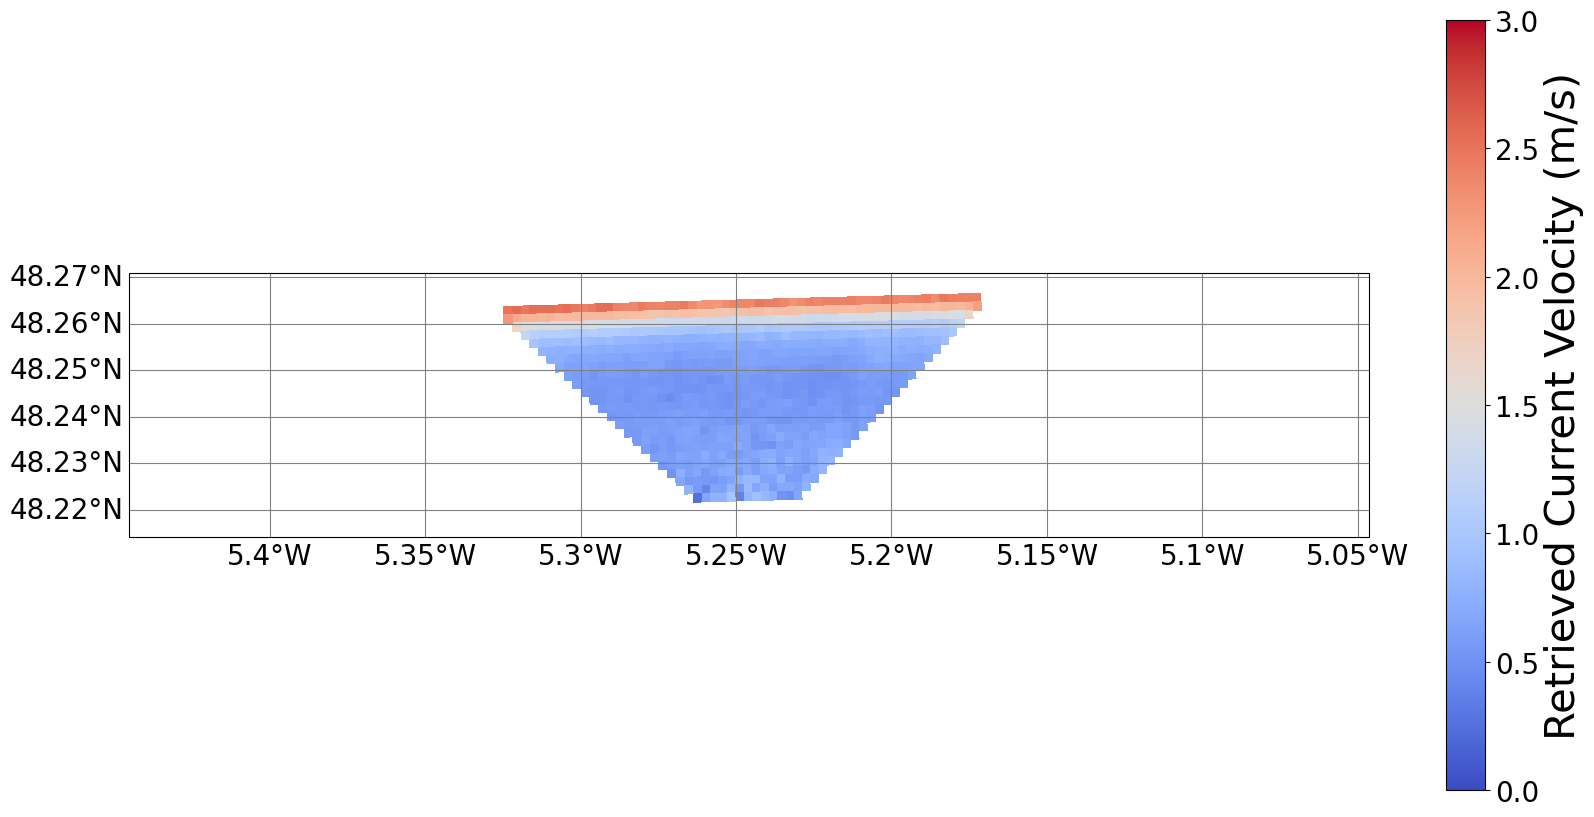

In [33]:
oscar_plot(ds_L2['Track_13'], 'CurrentVelocity', quivers=False, u='CurrentVectorUComponent', v='CurrentVectorVComponent')

In [77]:
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : ``xarray.Dataset``
        L1 dataset
    aux : ``xarray.Dataset``
        Dataset containing geophysical wind data
    gmf : ``str``, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    rsc : ``xarray.DataArray``
        Radial Surface Current

    """
    dswasv = seastar.gmfs.doppler.compute_wasv(level1, aux, gmf)
    rsc = level1.RadialSurfaceVelocity + dswasv

    rsc.attrs['long_name'] =\
        'Radial Surface Current'
    rsc.attrs['description'] =\
        'Radial Surface Current (RSC) along antenna beam direction, corrected'\
        'for Wind Artifact Surface Velocity (WASV)'
    rsc.attrs['units'] = 'm/s'

    return rsc

In [159]:
aux_list['Trefle']

<xarray.Dataset>
Dimensions:     (time: 1524, bin: 100)
Coordinates:
  * time        (time) datetime64[ns] 2022-05-13T12:00:00 ... 2022-05-24T01:5...
    depth       (bin) float32 3.0 4.0 5.0 6.0 7.0 ... 99.0 100.0 101.0 102.0
Dimensions without coordinates: bin
Data variables:
    longitude   (time) float64 -5.249 -5.249 -5.249 ... -5.249 -5.249 -5.25
    latitude    (time) float64 48.26 48.26 48.26 48.26 ... 48.25 48.25 48.25
    velocity_e  (time) float32 ...
    velocity_n  (time) float32 ...
    velocity_u  (time) float32 ...
    v_e         (time, bin) float32 ...
    v_n         (time, bin) float32 ...
    v_u         (time, bin) float32 ...
    RSSI        (time, bin) float32 ...
Attributes:
    Title:          SUMOS TREFLE Buoy RDI WH300 record
    Creation_date:  2022-06-04T11:41:53
    Contact:        L. MARIE : louis.marie@ifremer.fr
    Instrument:     TREFLE buoy RDI WorkHorse 300 kHz ADCP
    Manufacturer:   RDI
    Campaign:       SUMOS
    buoy_ID:        TREFLE 1